In [147]:
%matplotlib inline
import Quandl
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import scipy.stats
import pylab

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = True

In [148]:
## NUMBER OF ASSETS
n_assets = 6

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.matrix(get(['IBM', 'AAPL', 'HP', 'MSFT', 'ORCL', 'HAL' ], 'returns'))
return_vec

matrix([[ 9.8125  ,  1.499999, -1.8125  ,  4.5625  ,  5.625   ],
        [-1.4375  ,  0.687501, -1.25    ,  0.5     ,  0.5625  ],
        [ 0.8125  , -0.687501, -0.0625  ,  0.6875  , -2.4375  ],
        ..., 
        [-0.270004, -3.81002 ,  0.82    , -0.149998,  0.290001],
        [ 1.330002, -5.570008,  0.07    ,  0.      ,  0.010002],
        [ 1.160003,  6.500016,  0.050003,  0.119999,  0.269996]])

In [149]:
def get(ticker_list, kind = 'returns'):
    #takes in a ticker list and returns either a dataframe of closing price 'returns'
    #for each stock or closing 'prices'
    final_df = pd.DataFrame()
    for item in ticker_list:
        ticker = item
        temp_df = Quandl.get('YAHOO/'+str(ticker), 
                                         trim_start='2001-01-01', trim_end='2014-01-01', authtoken="H4uWGQ3jQdm96V7H2Abm")
        temp_df.index = pd.to_datetime(temp_df.index)
        temp_df = temp_df.sort()
        if (kind == 'prices'):
            add_series = temp_df.Close
        elif (kind == 'log_prices'):
            add_series = np.log(temp_df.Close);
        elif (kind == 'returns'):
            add_series = temp_df.Close.shift(-1) - temp_df.Close
            add_series.ix[:-1]
        else:
            add_series = np.log(temp_df.Close).shift(-1) - np.log(temp_df.Close)
        final_df[ticker] = add_series
        

    final_df = final_df.sort().ix[:-1]
    return final_df

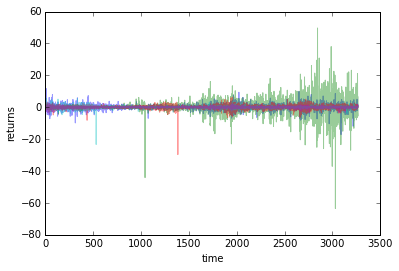

In [150]:
plt.plot(return_vec, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [137]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.24736414  0.33988876  0.12700932  0.03194877  0.25378901]
[ 0.19120429  0.2353157   0.27357236  0.16288808  0.13701957]


In [154]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    #print 'p:\n'
    #print p
    
    w = np.asmatrix(rand_weights(returns.shape[0])).T
    #print 'w:\n'
    #print w
    C = np.asmatrix(np.cov(returns))
    #print 'C:\n'
    #print C
    
    mu = w.T * p
    sigma = np.sqrt(w.T * C * w)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

random_portfolio(return_vec)

(matrix([[ 0.07361029]]), matrix([[ 0.12363858]]))

In [158]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

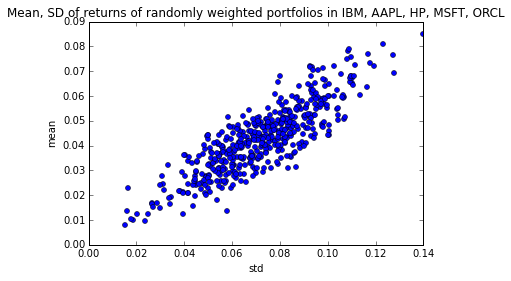

In [160]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean, SD of returns of randomly weighted portfolios in IBM, AAPL, HP, MSFT, ORCL')

In [161]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)


plt.title("Efficient Frontier (In Yellow)")
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

     pcost       dcost       gap    pres   dres
 0: -6.0542e+02 -1.8433e+01  9e+04  3e+02  4e+00
 1: -4.4432e+01 -1.6862e+01  5e+03  2e+01  2e-01
 2: -1.3301e+01 -1.0046e+01  7e+02  2e+00  3e-02
 3: -4.6524e+00 -7.1303e+00  1e+02  4e-01  6e-03
 4: -1.6714e+00 -6.1647e+00  2e+01  5e-02  7e-04
 5: -1.2379e+00 -6.7107e+00  1e+01  3e-02  4e-04
 6: -1.3573e+00 -5.3052e+00  7e+00  1e-02  2e-04
 7: -2.4526e+00 -5.9550e+00  7e+00  1e-02  2e-04
 8: -4.1086e+00 -5.2347e+00  2e+00  2e-03  3e-05
 9: -4.0458e+00 -5.2772e+00  2e+00  1e-03  2e-05
10: -3.8219e+00 -5.2179e+00  1e+00  3e-04  4e-06
11: -4.9802e+00 -5.1889e+00  2e-01  1e-15  3e-15
12: -5.1783e+00 -5.1805e+00  2e-03  2e-15  4e-15
13: -5.1804e+00 -5.1804e+00  2e-05  9e-16  4e-15
14: -5.1804e+00 -5.1804e+00  2e-07  7e-16  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.0394e+02 -1.7104e+01  9e+04  3e+02  4e+00
 1: -4.0790e+01 -1.5824e+01  5e+03  1e+01  2e-01
 2: -1.2052e+01 -9.6713e+00  7e+02  2e+00  3e-0

KeyboardInterrupt: 